In [2]:
%matplotlib inline
import tensorflow as tf
import scipy.io.wavfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

sess = tf.Session()

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

x_image = tf.reshape(x, [-1,28,28,1])


W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])


h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
h_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
y_conv=tf.nn.softmax(h_fc2)
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
sess.run(tf.initialize_all_variables())
finalRepresentations = []
for i in range(500):
    batch = mnist.train.next_batch(50)
    if (i%100 == 0):
        train_accuracy = accuracy.eval(session=sess,feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
        finalRepresentations.append(h_fc2.eval(session=sess, feed_dict={x:mnist.test.images, keep_prob:1.0}))

    train_step.run(session=sess,feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(session=sess,feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Use `tf.global_variables_initializer` instead.
step 0, training accuracy 0.06
step 100, training accuracy 0.84
step 200, training accuracy 0.92
step 300, training accuracy 0.98
step 400, training accuracy 0.88
test accuracy 0.9424


/Users/karanuppal/anaconda/envs/gl-env/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


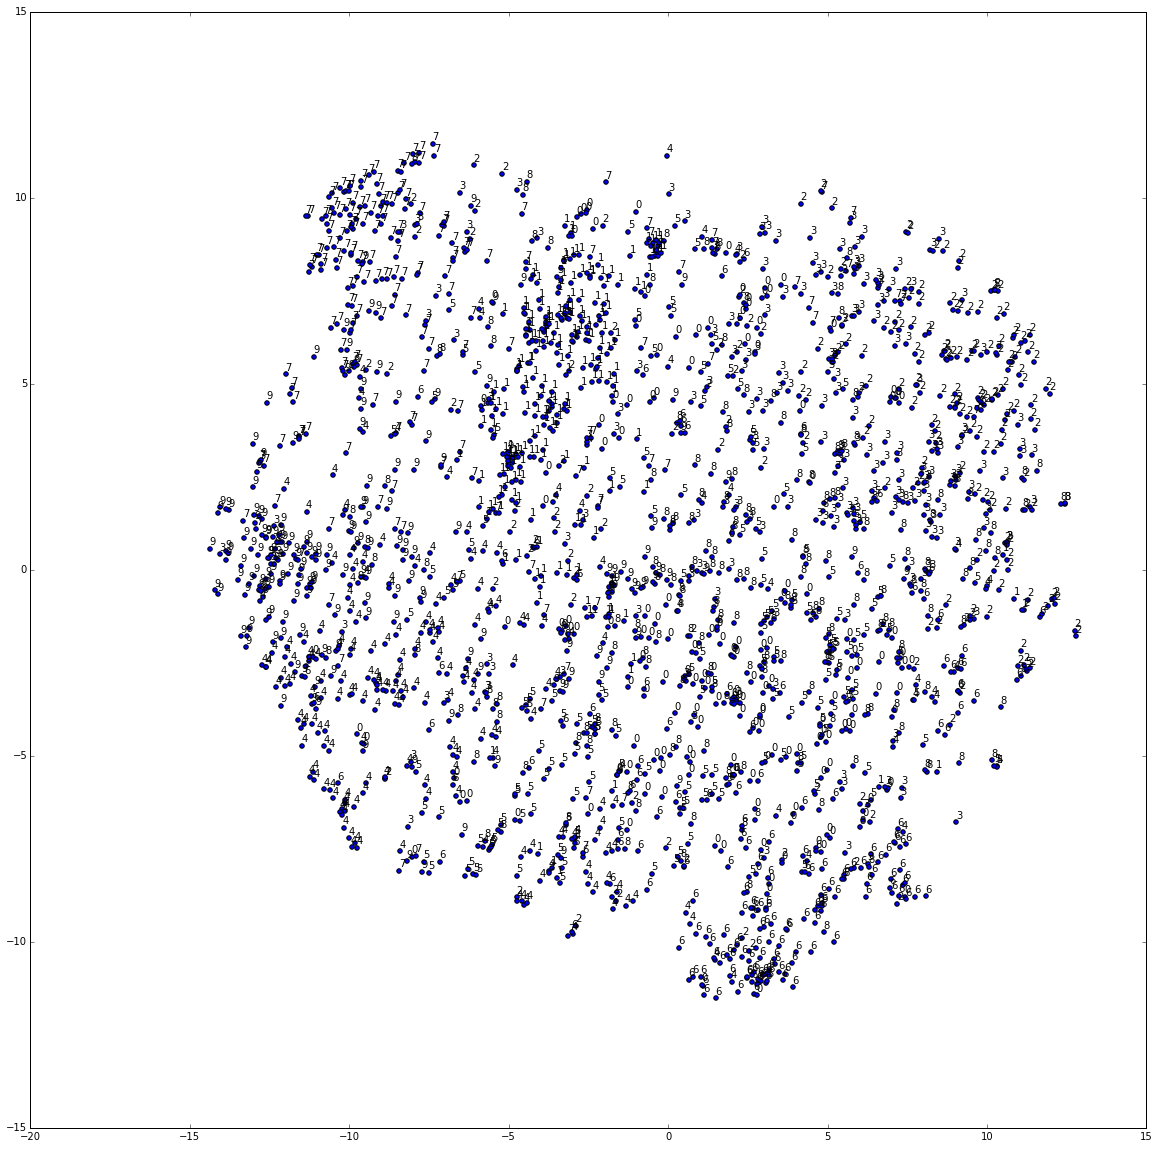

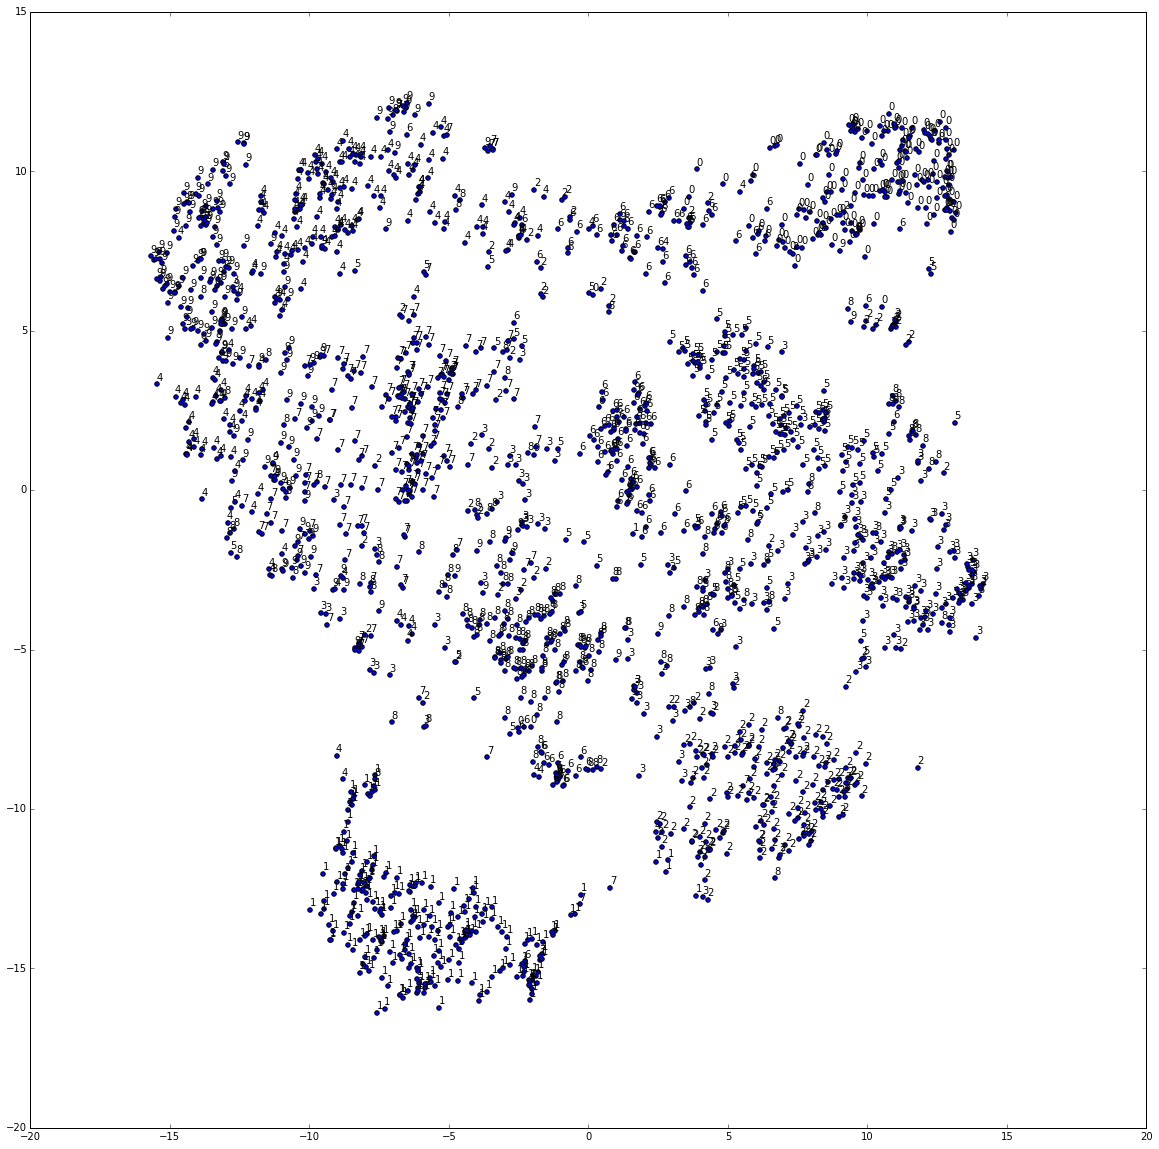

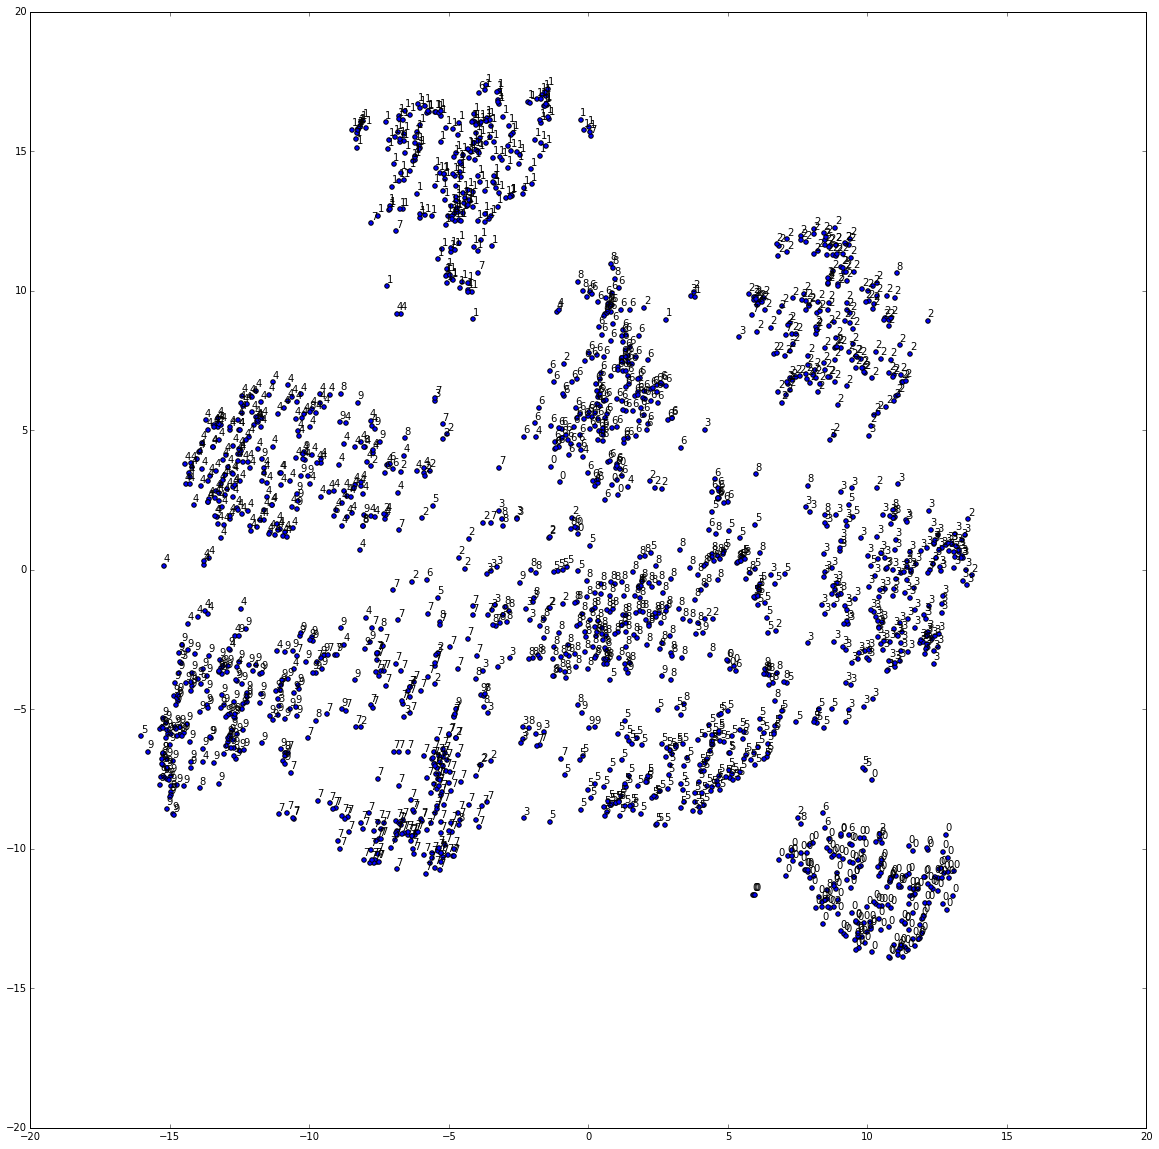

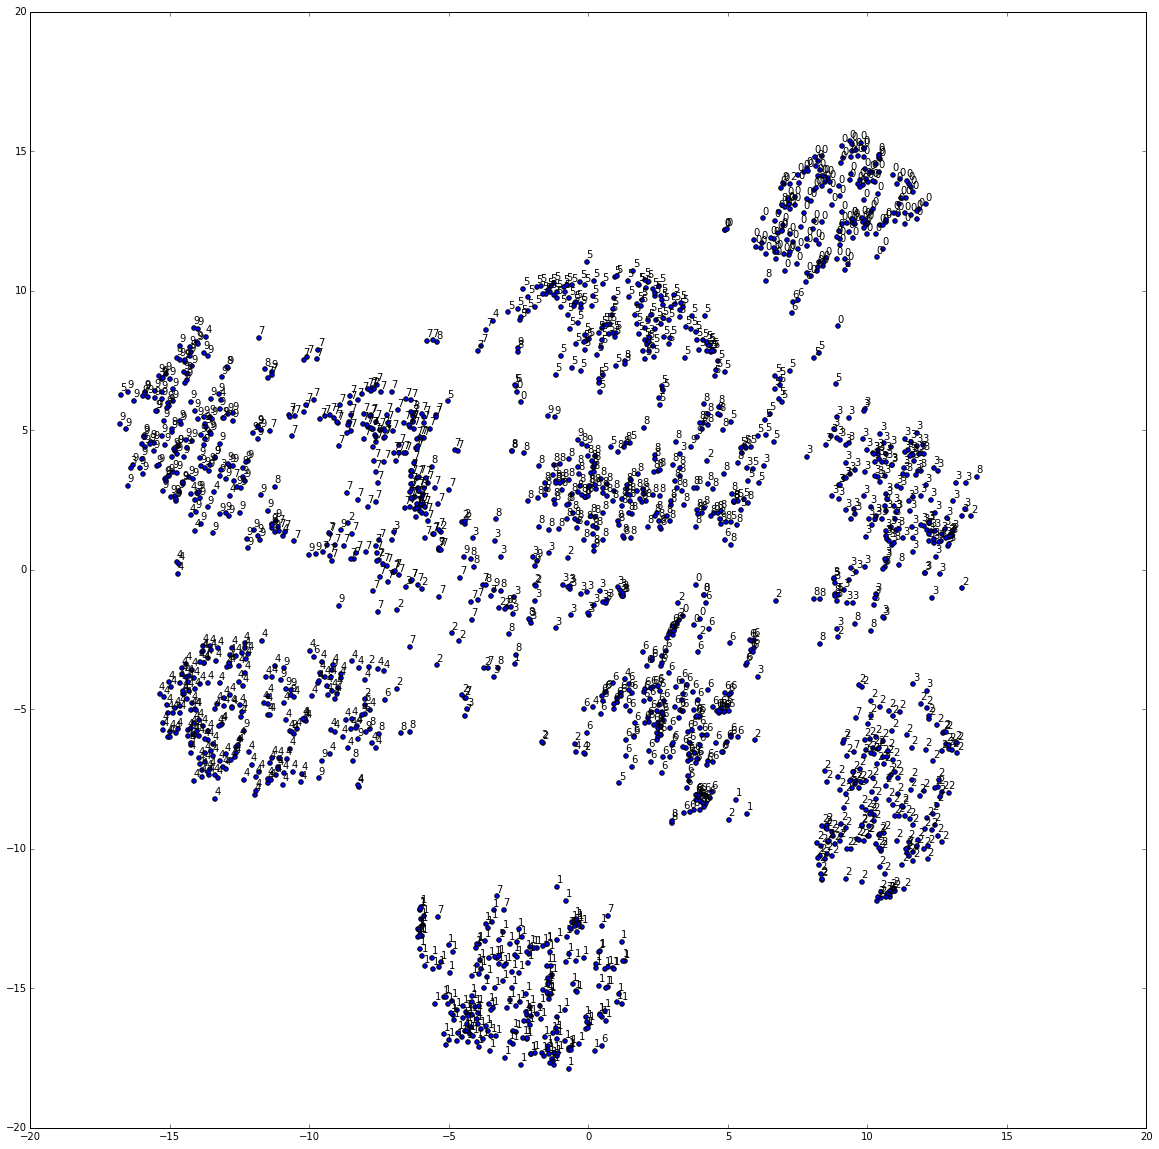

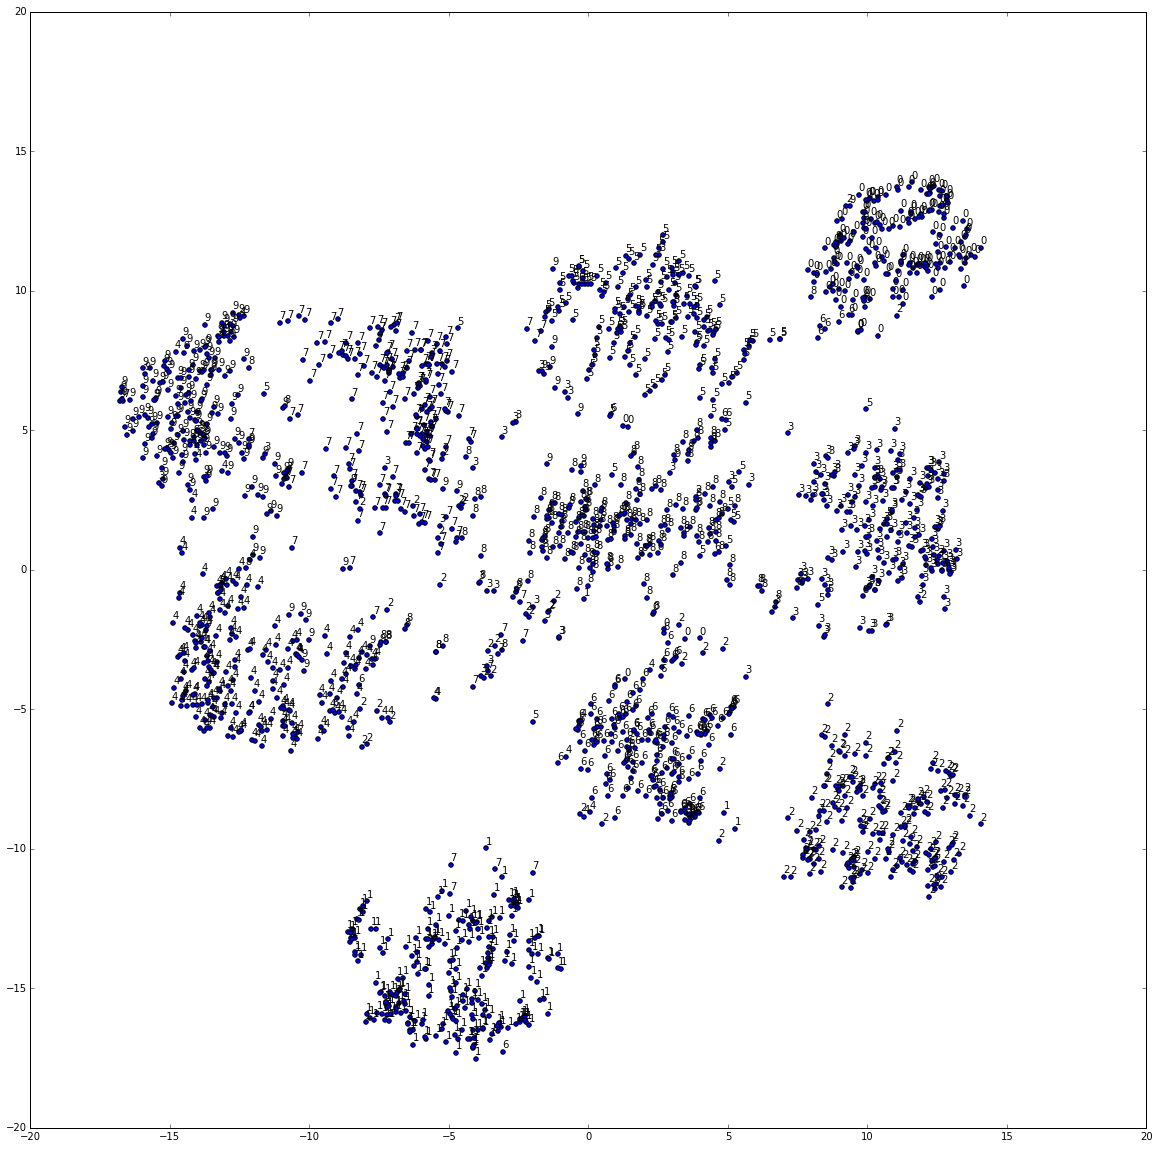

In [6]:
testY = np.argmax(mnist.test.labels,1)
finalWs = W_fc2.eval(session=sess)

def plot_with_labels(lowDWeights, labels, filename='tsne.png'):
    assert lowDWeights.shape[0] >= len(labels), "More labels than weights"
    plt.figure(figsize=(20, 20))  #in inches
    for i, label in enumerate(labels):
        x, y = lowDWeights[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

    plt.savefig(filename)
def plot_with_labels(lowDWeights, labels, filename='tsne.png'):
    assert lowDWeights.shape[0] >= len(labels), "More labels than weights"
    plt.figure(figsize=(20, 20))  #in inches
    for i, label in enumerate(labels):
        x, y = lowDWeights[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

    plt.savefig(filename)
    
iters = 0
for i in finalRepresentations:
    tsne = TSNE(perplexity=50, n_components=2, init='pca', n_iter=5000)
    plot_only = 2000
    lowDWeights = tsne.fit_transform(i[0:plot_only,:])
    labels = testY[0:plot_only]
    plot_with_labels(lowDWeights, labels, str(iters*100)+'.png')
    iters+=1    